In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qmcpy as qp # This is using the updated code in the PR

In [2]:
seed = 7

In [3]:
def eval_option(option_mc, option_qmc, abs_tol):
    stopping_criteria = {
        "MLMC old" : qp.CubMCML(option_mc, abs_tol=abs_tol, levels_max=15),
        "MLMC new" : qp.CubMCMLCont(option_mc, abs_tol=abs_tol, levels_max=15),
        "MLQMC old" : qp.CubQMCML(option_qmc, abs_tol=abs_tol, levels_max=15),
        "MLQMC new" : qp.CubQMCMLCont(option_qmc, abs_tol=abs_tol, levels_max=15)
    }
    
    levels = []
    times = []
    for name, stopper in stopping_criteria.items():
        sol, data = stopper.integrate()
        levels.append(data.levels)
        times.append(data.time_integrate)
        print("\t%-15s solution %-10.4f number of levels %-6d time %.3f"%(name, sol, levels[-1], times[-1]))
        
    return levels, times

In [4]:
# European option: giving accurate approximations
option_mc = qp.MLCallOptions(qp.IIDStdGaussian(seed=seed), option="european")
option_qmc = qp.MLCallOptions(qp.Sobol(seed=seed), option="european")
print("European Option true value: %.5f"%option_qmc.get_exact_value())
eval_option(option_mc, option_qmc, abs_tol=5e-3);

European Option true value: 10.45058
	MLMC old        solution 10.4491    number of levels 10     time 41.662
	MLMC new        solution 10.4449    number of levels 8      time 20.234
	MLQMC old       solution 10.4487    number of levels 9      time 2.357
	MLQMC new       solution 10.4470    number of levels 8      time 1.451


In [5]:
for level in range(5):
    aco = qp.AsianOption(qp.Sobol(2*2**level, seed=seed), volatility=.2, start_price=100, strike_price=100, interest_rate=.05)
    approx_solution, data = qp.CubQMCSobolG(aco, abs_tol=1e-5).integrate()
    print("Asian Option true value (level %d): %.5f (to within 1e-5)"%(level, approx_solution))

Asian Option true value (level 0): 5.63593 (to within 1e-5)
Asian Option true value (level 1): 5.73170 (to within 1e-5)
Asian Option true value (level 2): 5.75527 (to within 1e-5)
Asian Option true value (level 3): 5.76113 (to within 1e-5)
Asian Option true value (level 4): 5.76260 (to within 1e-5)


In [6]:
# Asian option: also giving accurate approximations?
option_mc = qp.MLCallOptions(qp.IIDStdGaussian(seed=seed), option="asian")
option_qmc = qp.MLCallOptions(qp.Sobol(seed=seed), option="asian")
eval_option(option_mc, option_qmc, abs_tol=5e-3);

	MLMC old        solution 5.7645     number of levels 10     time 11.370
	MLMC new        solution 5.7571     number of levels 7      time 10.234
	MLQMC old       solution 5.7611     number of levels 8      time 2.642
	MLQMC new       solution 5.7596     number of levels 7      time 1.491


In [7]:
repetitions = 10
tolerances = 5*np.logspace(-1, -3, num=5)

levels = {}
times = {}
for t in range(len(tolerances)):
    for r in range(repetitions):
        print("tolerance = %10.4e, repetition = %d/%d"%(tolerances[t], r + 1, repetitions))
        levels[t, r], times[t, r] = eval_option(option_mc, option_qmc, tolerances[t])

tolerance = 5.0000e-01, repetition = 1/10
	MLMC old        solution 5.7770     number of levels 3      time 0.008
	MLMC new        solution 5.7395     number of levels 3      time 0.012
	MLQMC old       solution 5.7060     number of levels 3      time 0.091
	MLQMC new       solution 5.7031     number of levels 3      time 0.096
tolerance = 5.0000e-01, repetition = 2/10
	MLMC old        solution 5.7753     number of levels 3      time 0.005
	MLMC new        solution 5.7803     number of levels 3      time 0.011
	MLQMC old       solution 5.7040     number of levels 3      time 0.085
	MLQMC new       solution 5.7062     number of levels 3      time 0.094
tolerance = 5.0000e-01, repetition = 3/10
	MLMC old        solution 5.7277     number of levels 3      time 0.005
	MLMC new        solution 5.6515     number of levels 3      time 0.011
	MLQMC old       solution 5.7036     number of levels 3      time 0.074
	MLQMC new       solution 5.7036     number of levels 3      time 0.067
tolerance 

	MLMC old        solution 5.7755     number of levels 7      time 0.148
	MLMC new        solution 5.7393     number of levels 5      time 0.110
	MLQMC old       solution 5.7451     number of levels 5      time 0.256
	MLQMC new       solution 5.7335     number of levels 4      time 0.146
tolerance = 5.0000e-02, repetition = 7/10
	MLMC old        solution 5.7532     number of levels 7      time 0.133
	MLMC new        solution 5.7461     number of levels 5      time 0.119
	MLQMC old       solution 5.7496     number of levels 5      time 0.242
	MLQMC new       solution 5.7327     number of levels 4      time 0.153
tolerance = 5.0000e-02, repetition = 8/10
	MLMC old        solution 5.7594     number of levels 7      time 0.137
	MLMC new        solution 5.7380     number of levels 4      time 0.059
	MLQMC old       solution 5.7486     number of levels 5      time 0.256
	MLQMC new       solution 5.7346     number of levels 4      time 0.160
tolerance = 5.0000e-02, repetition = 9/10
	MLMC old 

In [8]:
avg_time = {}
for method in range(4):
    avg_time[method] = [np.mean([times[t, r][method] for r in range(repetitions)]) for t in range(len(tolerances))]

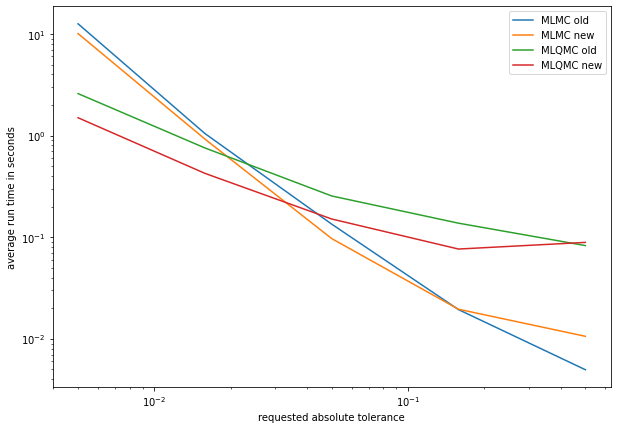

In [9]:
plt.figure(figsize=(10,7))
plt.plot(tolerances, avg_time[0], label="MLMC old")
plt.plot(tolerances, avg_time[1], label="MLMC new")
plt.plot(tolerances, avg_time[2], label="MLQMC old")
plt.plot(tolerances, avg_time[3], label="MLQMC new")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("requested absolute tolerance")
plt.ylabel("average run time in seconds")
plt.legend()

In [10]:
max_levels = {}
for method in range(4):
    levels_rep = np.array([levels[len(tolerances)-1, r][method] for r in range(repetitions)])
    max_levels[method] = [np.count_nonzero(levels_rep == level)/repetitions for level in range(15)]

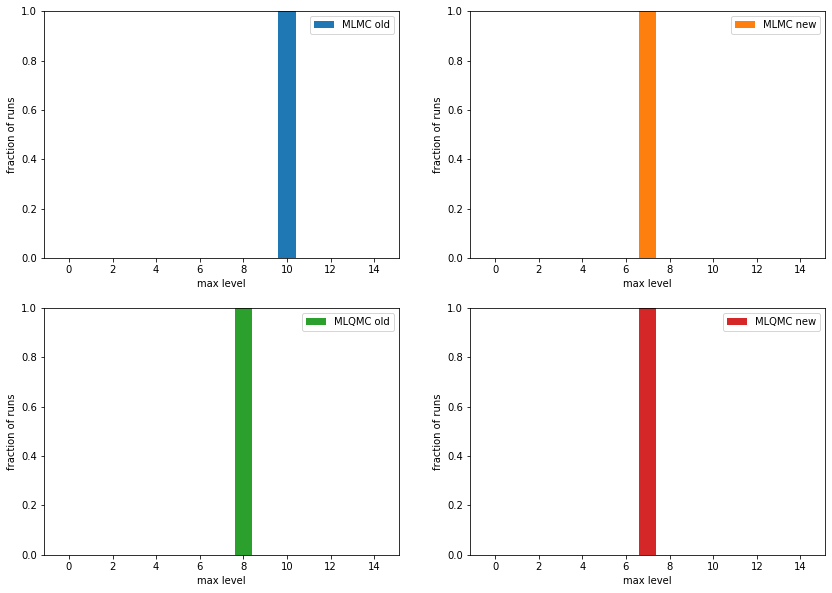

In [11]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1); plt.bar(range(15), max_levels[0], label="MLMC old", color="C0"); plt.xlabel("max level"); plt.ylabel("fraction of runs"); plt.ylim(0, 1); plt.legend()
plt.subplot(2,2,2); plt.bar(range(15), max_levels[1], label="MLMC new", color="C1"); plt.xlabel("max level"); plt.ylabel("fraction of runs"); plt.ylim(0, 1); plt.legend()
plt.subplot(2,2,3); plt.bar(range(15), max_levels[2], label="MLQMC old", color="C2"); plt.xlabel("max level"); plt.ylabel("fraction of runs"); plt.ylim(0, 1); plt.legend()
plt.subplot(2,2,4); plt.bar(range(15), max_levels[3], label="MLQMC new", color="C3"); plt.xlabel("max level"); plt.ylabel("fraction of runs"); plt.ylim(0, 1); plt.legend()